# Reparameterizing distributions in numpyro

Every single time I've tried to "chance" it with probabilistic methods I am once again reminded that you can't treat them like a black box. The following is a self-contained example of a pathological case so simple it almost feels like it should just work, and yet it fails miserably without intervention (in this case by reparameterizing the distributions). Part of me wonders if this all just means we need better tools or whether we just have to accept the fundamental complexity and model defensively.

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from jax import lax
from jax import numpy as jnp
from jax.random import PRNGKey
from matplotlib import pyplot as plt
from numpyro import deterministic, handlers, sample
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, autoguide, reparam
from numpyro.optim import Adam

sns.set_theme('talk', 'ticks', font='Arial', font_scale=1.0, rc={'svg.fonttype': 'none'})

## Problem setting

Consider a catalyzed reaction $A \xrightarrow{\mathrm{cat}} \cdots$ where the catalyst itself is slowly undergoing decomposition $\mathrm{cat} \rightarrow \cdots$. Initial concentrations $[A]_0$ and 

$\frac{d [A]}{d t} = -k[A][\mathrm{cat}]$  
$\frac{d [\mathrm{cat}]}{d t} = -k_d[\mathrm{cat}]$

A couple of simple helper functions to integrate these differential equations.

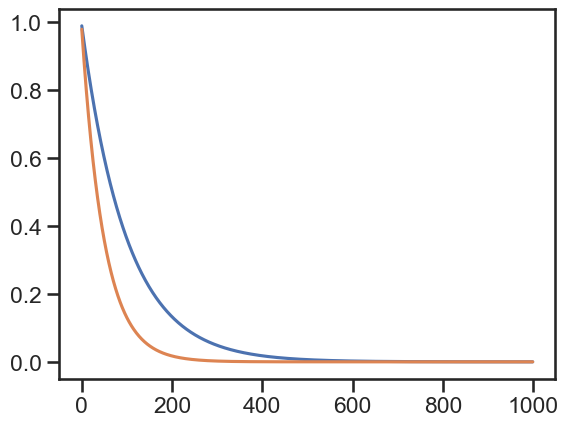

In [2]:
def solve(a_0, k, cats, dt):
    return lax.scan(lambda a_n, cat: (a_n - dt * k * cat * a_n, a_n - dt * k * cat * a_n), a_0, cats)[1]

def solve_cat(cat_0, k_d, dt, n):
    return lax.scan(lambda cat_n, _: (cat_n - dt * k_d * cat_n, cat_n - dt * k_d * cat_n), cat_0, length=n)[1]
    

plt.plot(solve(1.0, 1.0, jnp.ones((1000,)), 0.01))
plt.plot(solve_cat(1.0, 1.0, 0.02, 1000))

Now a simple model, first without worrying about measurement error. We'll use both MCMC and SVI.

In [32]:
def model(a_0, cat_0, dt, n):
    k = sample('k', dist.LogNormal(0.0, 1.0))
    k_d = sample('k_d', dist.LogNormal(-2.0, 1.0))
    cats = deterministic('cat', solve_cat(cat_0, k_d, dt, n))
    a_n = deterministic('a_n', solve(a_0, k, cats, dt))

args = (1.0, 0.1, 0.01, 500)
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=100)
mcmc.run(PRNGKey(0), *args)
mcmc_samples = mcmc.get_samples()

guide = autoguide.AutoNormal(model)
svi = SVI(model, guide, Adam(0.01), Trace_ELBO())
svi_result = svi.run(PRNGKey(1), 2000, *args)
svi_samples = guide.sample_posterior(PRNGKey(0), svi_result.params, sample_shape=(100,))

100%|██████████| 2000/2000 [00:00<00:00, 4384.19it/s, init loss: 7.5166, avg. loss [1901-2000]: 0.0118]


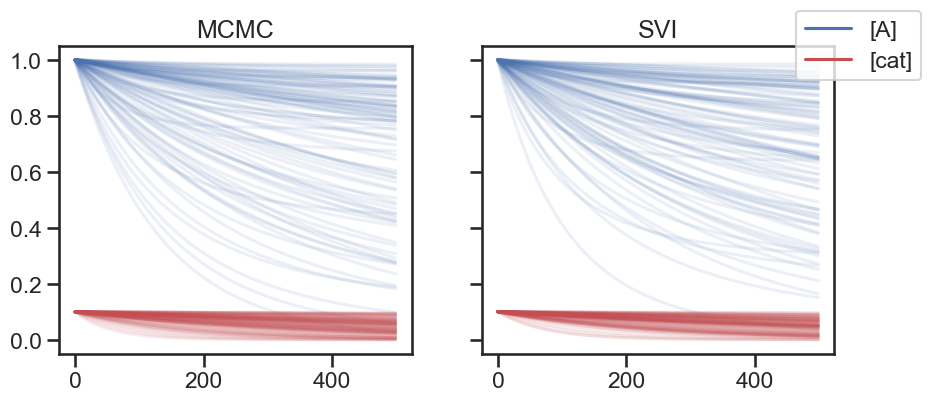

In [33]:
f, (a1, a2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
a1.set_title('MCMC')
a2.set_title('SVI')

a_line, *_ = a1.plot(mcmc_samples['a_n'].T, c='b', alpha=0.1, label='[A]')
a_line.set_alpha(1)
cat_line, *_ = a1.plot(mcmc_samples['cat'].T, c='r', alpha=0.1, label='[cat]')
cat_line.set_alpha(1)
a2.plot(svi_samples['a_n'].T, c='b', alpha=0.1)
a2.plot(svi_samples['cat'].T, c='r', alpha=0.1)
f.legend(handles=[a_line, cat_line])
a_line.set_alpha(0.1)
cat_line.set_alpha(0.1)

Very nice, we get a range of $[A]$ trajectories based on possible $k$'s but also $k_d$'s. But now let's just sample simulate adding measurement error as a `LogNormal`. The previous variables shouldn't be affected because we are not making an observation. What's notable about this `a_draw` variable is that it has a very narrow distribution ($\sigma$ = 0.02).

In [29]:
def model(a_0, cat_0, dt, n, err):
    k = sample('k', dist.LogNormal(0.0, 1.0))
    k_d = sample('k_d', dist.LogNormal(-2.0, 1.0))
    cats = deterministic('cat', solve_cat(cat_0, k_d, dt, n))
    a_n = deterministic('a_n', solve(a_0, k, cats, dt))
    a_draw = sample('a_draw', dist.LogNormal(jnp.log(a_n), err))

args = (1.0, 0.1, 0.01, 500, 0.05)
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=100)
mcmc.run(PRNGKey(0), *args)
mcmc_samples = mcmc.get_samples()

guide = autoguide.AutoNormal(model)
svi = SVI(model, guide, Adam(0.01), Trace_ELBO())
svi_result = svi.run(PRNGKey(1), 2000, *args)
svi_samples = guide.sample_posterior(PRNGKey(0), svi_result.params, sample_shape=(100,))

100%|██████████| 2000/2000 [00:00<00:00, 2674.99it/s, init loss: 139124.0000, avg. loss [1901-2000]: 26.2503]


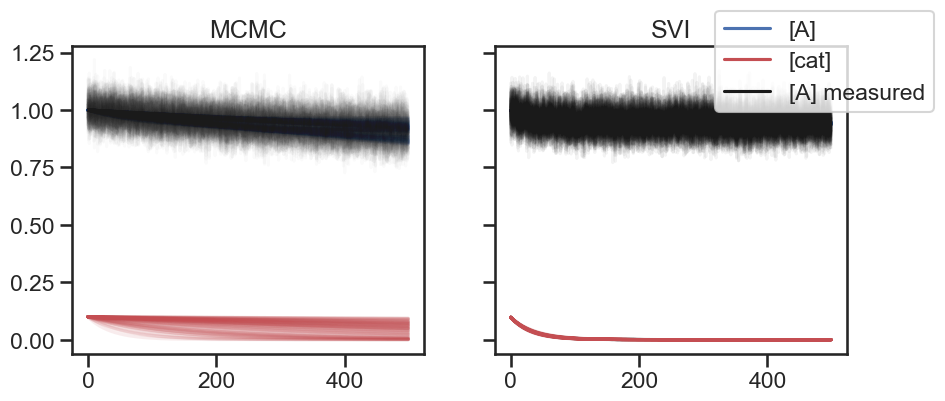

In [30]:
f, (a1, a2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
a1.set_title('MCMC')
a2.set_title('SVI')

a_line, *_ = a1.plot(mcmc_samples['a_n'].T, c='b', alpha=0.1, label='[A]')
a_line.set_alpha(1)
cat_line, *_ = a1.plot(mcmc_samples['cat'].T, c='r', alpha=0.1, label='[cat]')
cat_line.set_alpha(1)
meas_line, *_ = a1.plot(mcmc_samples['a_draw'].T, c='k', alpha=0.02, label='[A] measured')
meas_line.set_alpha(1)
a2.plot(svi_samples['a_n'].T, c='b', alpha=0.1)
a2.plot(svi_samples['cat'].T, c='r', alpha=0.1)
a2.plot(svi_samples['a_draw'].T, c='k', alpha=0.05)
f.legend(handles=[a_line, cat_line, meas_line])
a_line.set_alpha(0.1)
cat_line.set_alpha(0.1)
meas_line.set_alpha(0.02)

Yes, not looking good at all. We were expecting the exact sample plots! I tried increasing the number of samples, warmup and SVI steps and those didn't help either. The culprit is clearly the narrow distribution of `a_draw` as increasing its std to 1.0 everything goes back to normal.

After a bit of head scratching, it turns out there is a way to fix this without rewriting the model and manually de-centering/scaling. This happens on the level of the `Normal` distributions being sampled with ($\mu = 0$ and $\sigma = 1.0$) but the `LogNormal` distribution is a further exponential transform away from so that's where `TransformReparam` comes in.

In [34]:
reparam_config = {
    'k': reparam.TransformReparam(),
    'k_d': reparam.TransformReparam(),
    'a_draw': reparam.TransformReparam(),
    'k_base': reparam.LocScaleReparam(0),
    'k_d_base': reparam.LocScaleReparam(0),
    'a_draw_base': reparam.LocScaleReparam(0),
}

def model(a_0, cat_0, dt, n, err):
    k = sample('k', dist.LogNormal(0.0, 1.0))
    k_d = sample('k_d', dist.LogNormal(-2.0, 1.0))
    cats = deterministic('cat', solve_cat(cat_0, k_d, dt, n))
    a_n = deterministic('a_n', solve(a_0, k, cats, dt))
    a_draw = sample('a_draw', dist.LogNormal(jnp.log(a_n), err))

model = handlers.reparam(model, reparam_config)

args = (1.0, 0.1, 0.01, 500, 0.05)
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=100)
mcmc.run(PRNGKey(0), *args)
mcmc_samples = mcmc.get_samples()

guide = autoguide.AutoNormal(model)
svi = SVI(model, guide, Adam(0.01), Trace_ELBO())
svi_result = svi.run(PRNGKey(1), 2000, *args)
svi_samples = guide.sample_posterior(PRNGKey(0), svi_result.params, sample_shape=(100,))

100%|██████████| 2000/2000 [00:00<00:00, 3245.90it/s, init loss: 1233.4703, avg. loss [1901-2000]: 2.5142]


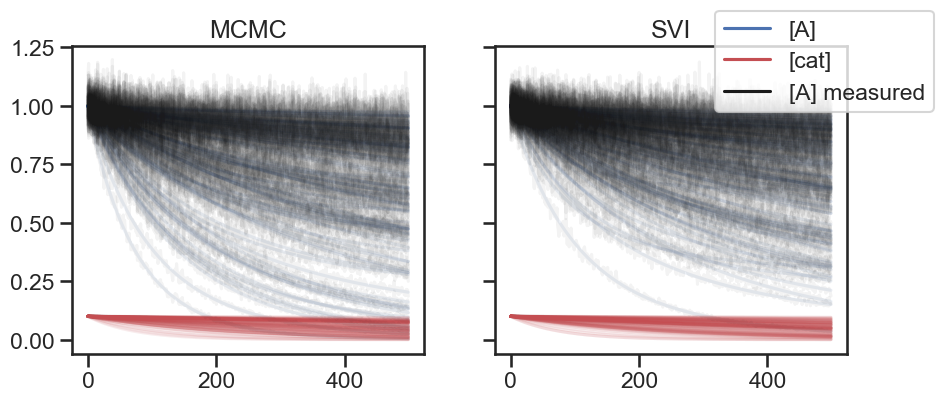

In [35]:
f, (a1, a2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
a1.set_title('MCMC')
a2.set_title('SVI')

a_line, *_ = a1.plot(mcmc_samples['a_n'].T, c='b', alpha=0.1, label='[A]')
a_line.set_alpha(1)
cat_line, *_ = a1.plot(mcmc_samples['cat'].T, c='r', alpha=0.1, label='[cat]')
cat_line.set_alpha(1)
meas_line, *_ = a1.plot(mcmc_samples['a_draw'].T, c='k', alpha=0.05, label='[A] measured')
meas_line.set_alpha(1)
a2.plot(svi_samples['a_n'].T, c='b', alpha=0.1)
a2.plot(svi_samples['cat'].T, c='r', alpha=0.1)
a2.plot(svi_samples['a_draw'].T, c='k', alpha=0.05)
f.legend(handles=[a_line, cat_line, meas_line])
a_line.set_alpha(0.1)
cat_line.set_alpha(0.1)
meas_line.set_alpha(0.02)

Beautiful! The latent concentrations are now exactly as before and we also have a nice extra variable showing measurement with error. How about a quick look at the sampled values of $k$ and $k_d$, which should ideally be uncorrelated and have a lognormal marginal, i.e. each is lognormally distributed irrespective of the other one.

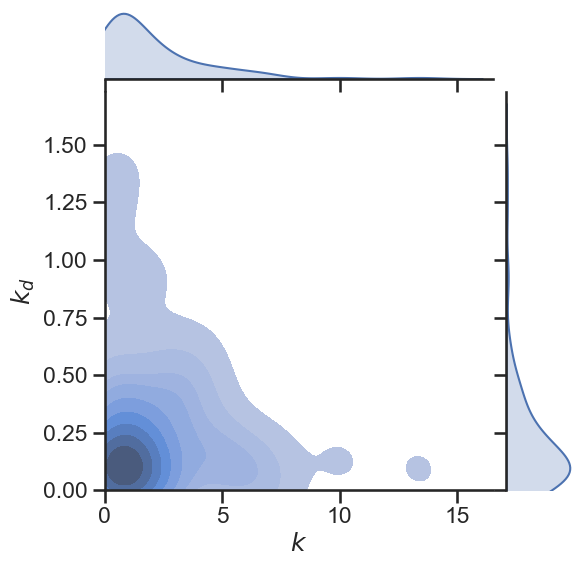

In [36]:
def posterior_df(samples):
    dfs = []

    for var, vals in samples.items():
        dfs.append(pd.DataFrame(samples[var]).melt().rename(columns={"value": var})[[var]])
    
    return pd.concat([dfs[0], *[df.iloc[:, 0] for df in dfs[1:]]], axis=1)

sns.jointplot(posterior_df(mcmc_samples), x='k', y='k_d', kind='kde', fill=True)
plt.gca().set(ylabel='$k_d$', xlabel='$k$')
plt.gca().set_xlim(left=0.0)
plt.gca().set_ylim(bottom=0.0);

Nice, normal as expected!

You will notice a quirk: I had to know that the name of the underlying `Normal` sites. And one downside of using this automatic reparameterisation is that `TransformReparam` doesn't currently support observations. That's fine though, you can split the sampled and observed parts (the observed part won't need reparameterising as it won't need to be sampled).

## Adding support for observations

Visualising the prior predictive, i.e. what's predicted solely from our priors without observing anything is nice but not that exciting. It took some trial and error to find the right combination of types and effect handlers to do this but the solution is to use a masked distribution. Here is how it works:

1. For any unobserved values in `a_draw` that need imputing (i.e. drawing from the prior predictive rather than observing), we can continue to use our reparamterized `TransformedDistribution`, but masked so the log probability of the any observed sites is ignored. Essentially, you are still sampling them but not accounting for their log probability, since we are later going to observe them.
2. For any observed values in `a_draw_obs`, reparameterizing is not necessary, since we are not going to sample them. We apply the opposite mask: observed values simply add to our overall joint log probability without having to be sampled; unobserved values are also observed from the imputed values but their log probs are ignored because we mask them. This is because we already calculated their log prob in the `a_draw` site.

I have to confess that this took a while to get right. Especially because some of the types don't compose very well, so for example `TransformedDistribution(MaskedDistribution(...))` is not supported but using a `mask` handler works.

In [58]:
reparam_config = {
    'k': reparam.TransformReparam(),
    'k_d': reparam.TransformReparam(),
    'a_draw': reparam.TransformReparam(),
    'k_base': reparam.LocScaleReparam(0),
    'k_d_base': reparam.LocScaleReparam(0),
    'a_draw_base': reparam.LocScaleReparam(0),
}

def model(a_0, cat_0, dt, n, err, obs):
    has_obs = ~jnp.isnan(obs)
    k = sample('k', dist.LogNormal(0.0, 1.0))
    k_d = sample('k_d', dist.LogNormal(-2.0, 1.0))
    cats = deterministic('cat', solve_cat(cat_0, k_d, dt, n))
    a_n = deterministic('a_n', solve(a_0, k, cats, dt))
    with handlers.mask(mask=~has_obs):
        d = dist.Normal(jnp.log(a_n), err)
    a_draw = sample('a_draw', dist.TransformedDistribution(d, dist.transforms.ExpTransform()))
    obs = jnp.where(has_obs, obs, a_draw)
    a_draw_combined = deterministic('a_draw_combined', obs)
    a_draw_obs = sample('a_draw_obs', dist.LogNormal(jnp.log(a_n), err).mask(has_obs), obs=obs)

def infer(model, args, guide=None):
    mcmc = MCMC(NUTS(model), num_warmup=2000, num_samples=100)
    mcmc.run(PRNGKey(0), *args)
    mcmc_samples = mcmc.get_samples()

    guide = guide or autoguide.AutoNormal(model)
    svi = SVI(model, guide, Adam(0.01), Trace_ELBO())
    svi_result = svi.run(PRNGKey(1), 10000, *args)
    svi_samples = guide.sample_posterior(PRNGKey(0), svi_result.params, sample_shape=(100,))
    return locals()


model = handlers.reparam(model, reparam_config)

obs = np.full((500,), np.nan)
args = (1.0, 0.1, 0.01, 500, 0.05, obs)

results = infer(model, args)

100%|██████████| 10000/10000 [00:01<00:00, 5173.40it/s, init loss: 1233.4703, avg. loss [9501-10000]: 2.4468]


Sampling from the prior predictive, i.e. when the observations are all `np.nan`.

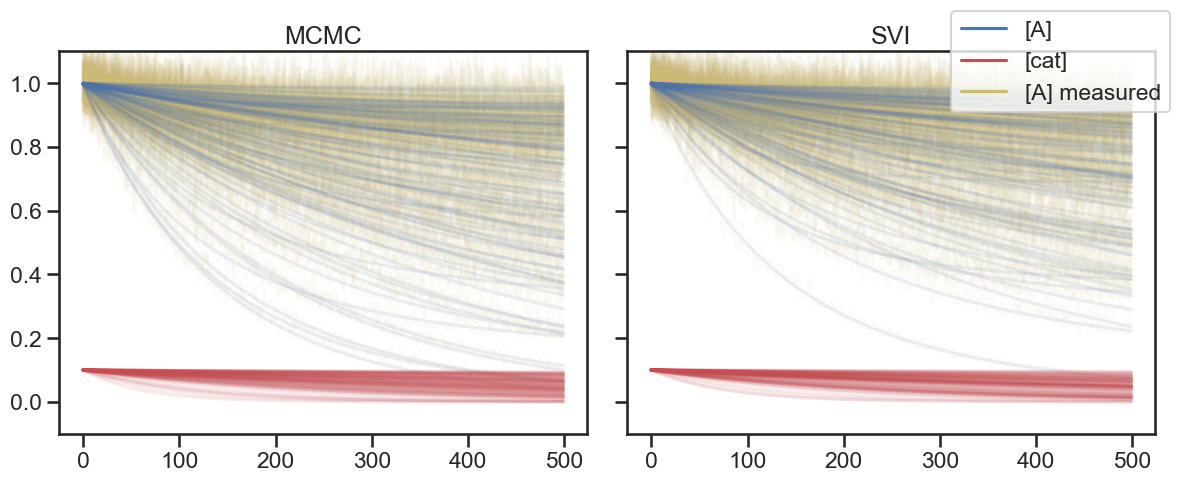

In [40]:
def plot_samples(mcmc_samples, svi_samples, obs):
    f, (a1, a2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
    a1.set_title('MCMC')
    a2.set_title('SVI')
    has_obs = ~jnp.isnan(obs)


    a_line, *_ = a1.plot(mcmc_samples['a_n'].T, c='b', alpha=0.1, label='[A]')
    a_line.set_alpha(1)
    cat_line, *_ = a1.plot(mcmc_samples['cat'].T, c='r', alpha=0.1, label='[cat]')
    cat_line.set_alpha(1)
    meas_line, *_ = a1.plot(mcmc_samples['a_draw_combined'].T, c='y', alpha=0.05, label='[A] measured', zorder=-1)
    meas_line.set_alpha(1)
    a2.plot(svi_samples['a_n'].T, c='b', alpha=0.1)
    a2.plot(svi_samples['cat'].T, c='r', alpha=0.1)
    a2.plot(svi_samples['a_draw_combined'].T, c='y', alpha=0.05, zorder=-1)
    f.legend(handles=[a_line, cat_line, meas_line])
    a1.scatter(jnp.nonzero(has_obs)[0], obs[has_obs], c='k', zorder=10)
    a2.scatter(jnp.nonzero(has_obs)[0], obs[has_obs], c='k', zorder=10)
    a1.set(ylim=(-0.1,1.1))
    a_line.set_alpha(0.1)
    cat_line.set_alpha(0.1)
    meas_line.set_alpha(0.05)
    return f

plot_samples(results['mcmc_samples'], results['svi_samples'], obs)
plt.tight_layout()

Now let's supply a single observation, specifically one that suggests the reaction is faster than predicted by most trajectories. In the posterior we would expect to see either a higher than anticipated $k$ or a lower than anticipated $k_d$ and the two should be positively **correlated**.

100%|██████████| 10000/10000 [00:02<00:00, 4996.71it/s, init loss: 1234.0802, avg. loss [9501-10000]: 3.8389]


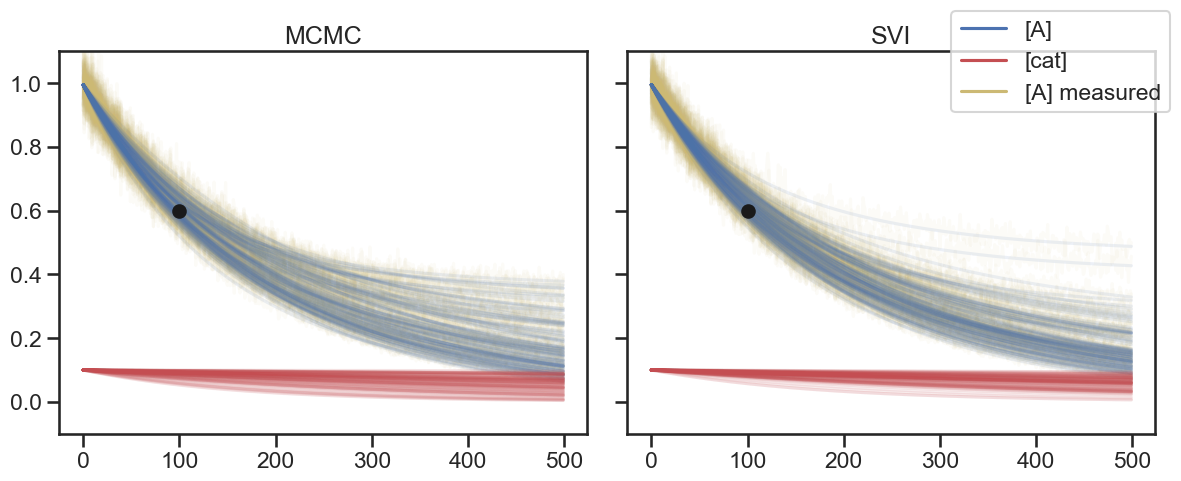

In [63]:
obs[100] = 0.6

args = (1.0, 0.1, 0.01, 500, 0.05, obs)

results = infer(model, args)

plot_samples(results['mcmc_samples'], results['svi_samples'], obs)
plt.tight_layout()

[Text(0.5, 0, '$k$'), Text(0, 0.5, '$k_d$')]

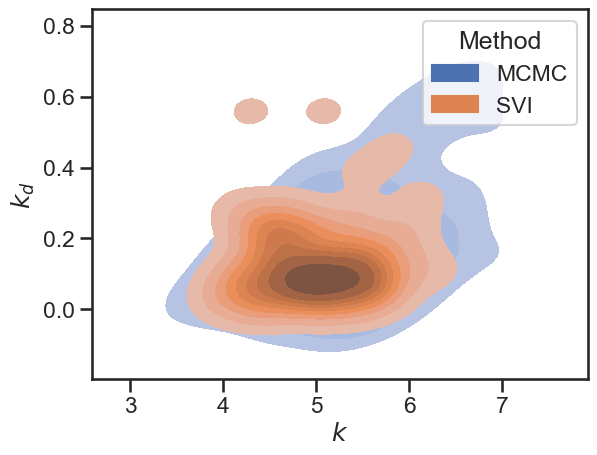

In [64]:
all_data = pd.concat([
    posterior_df(results['mcmc_samples'])[['k', 'k_d']].assign(Method='MCMC'),
    posterior_df(results['svi_samples'])[['k', 'k_d']].assign(Method='SVI'),
    ], ignore_index=True)
sns.kdeplot(all_data, x='k', y='k_d', hue="Method", fill=True)
plt.gca().set(xlabel='$k$', ylabel='$k_d$')

And here we go, a very different picture now, and as expected the `AutoNormal` SVI guide fails to capture the correlation between $k$ and $k_d$. A full rank multivariate normal should be able to handle this, albeit taking about 10x as long as MCMC. For some reason `autoguide.AutoLowRankMultivariateNormal(rank=2)` doesn't seem to do the trick.

A more advanced option to get the best of both worlds would be creating a separate full-rank guide for $k$ and $k_d$ then using a simple `AutoNormal` for the rest (specifically `a_draw`) using `AutoGuideList`.

In [ ]:
# "Easy" but slow and doesn't really scale
# results = infer(model, args, autoguide.AutoMultivariateNormal(model))

# More involved but very fast
guide = autoguide.AutoGuideList(model)
guide.append(autoguide.AutoNormal(handlers.block(model, expose=['a_draw_base_decentered'])))
guide.append(autoguide.AutoMultivariateNormal(handlers.block(model, expose=['k_base_decentered', 'k_d_base_decentered'])))
results = infer(model, args, guide)

100%|██████████| 10000/10000 [00:02<00:00, 4894.64it/s, init loss: 1272.4036, avg. loss [9501-10000]: 3.7564]


 This is more involved and it seems like `AutoGuideList` doesn't deal with deterministic sites, so we have derive them manually. I had to read a lot of numpyro's source code to figure out how.

In [ ]:
from numpyro.infer.util import soft_vmap

def predictive(sample):
    with handlers.seed(rng_seed=PRNGKey(0)):
        with handlers.substitute(data=sample):
            return {k: v['value'] for k, v in handlers.trace(model).get_trace(*args).items()}

results['svi_samples'].update(soft_vmap(predictive, results['svi_samples']))

[Text(0.5, 0, '$k$'), Text(0, 0.5, '$k_d$')]

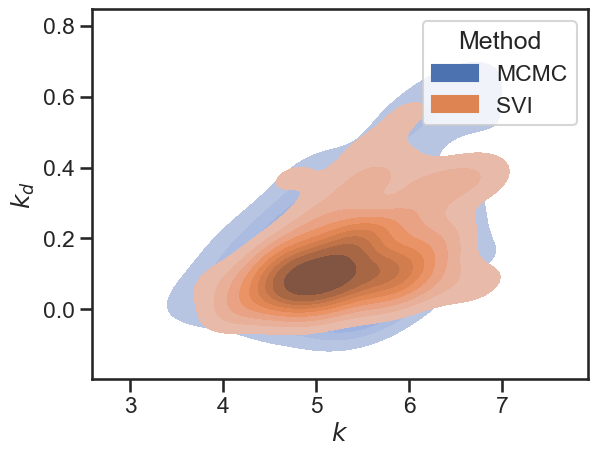

In [136]:
all_data = pd.concat([
    posterior_df(results['mcmc_samples'])[['k', 'k_d']].assign(Method='MCMC'),
    posterior_df(results['svi_samples'])[['k', 'k_d']].assign(Method='SVI'),
    ], ignore_index=True)
sns.kdeplot(all_data, x='k', y='k_d', hue="Method", fill=True)
plt.gca().set(xlabel='$k$', ylabel='$k_d$')

And here we go!

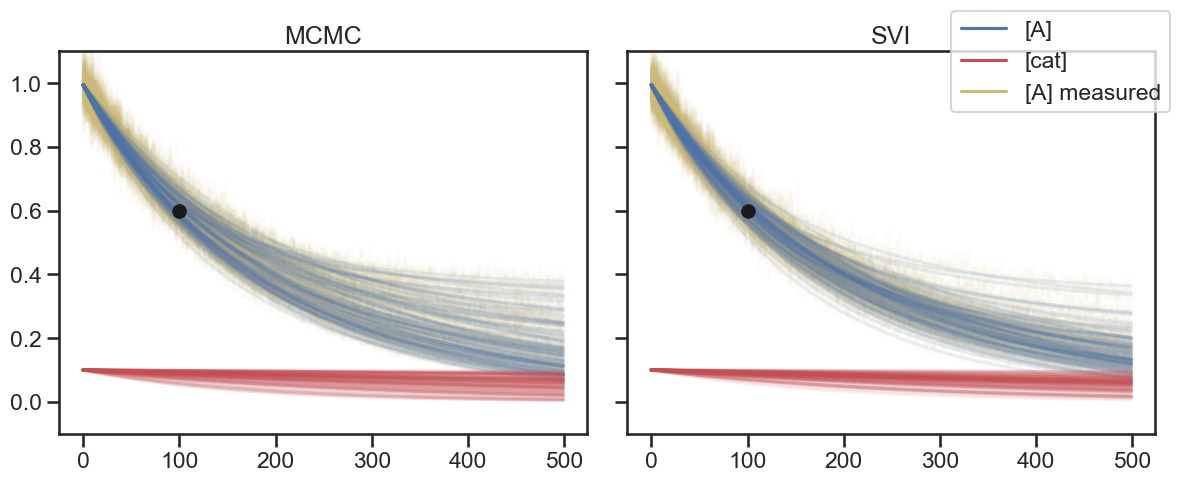

In [137]:
plot_samples(results['mcmc_samples'], results['svi_samples'], obs)
plt.tight_layout()

I hope this was fun to explore together. Very happy to chat if you have any suggestions or questions. This experiment was motivated by my upcoming RSC book on digital chemistry, as part of which I am hoping to present probabilistic programming as a powerful data interpretation aid for experimentalists working with automated platforms that can generate a wealth of experimental data.